In [30]:
import happybase
import pandas as pd
import os
import findspark
import copy
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from datetime import datetime
from typing import List
from functools import reduce
from pyspark.sql import SparkSession, SQLContext, DataFrame
from pyspark import SparkContext, SparkConf
from pyspark.sql.functions import lower, col, length
import subprocess

findspark.init()

In [2]:
master= "local"
spark = (SparkSession.builder
         .master(master)
         .appName('final')
         .enableHiveSupport()
         .getOrCreate())

23/01/12 19:36:24 WARN util.Utils: Your hostname, node1 resolves to a loopback address: 127.0.0.1; using 192.168.137.188 instead (on interface ens3)
23/01/12 19:36:24 WARN util.Utils: Set SPARK_LOCAL_IP if you need to bind to another address
23/01/12 19:36:25 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [3]:
spark.sql('show tables').show()

+--------+--------------------+-----------+
|database|           tableName|isTemporary|
+--------+--------------------+-----------+
| default|           employees|      false|
| default|external_table_trams|      false|
| default|external_table_tr...|      false|
| default|                imdb|      false|
| default|            salaries|      false|
| default|                wifi|      false|
| default|               wifi1|      false|
| default|               wifi2|      false|
| default|            wifi_par|      false|
+--------+--------------------+-----------+



## Loading data

In [5]:
imdb = spark.sql("select distinct * from imdb")

In [11]:
# read data for reddit
reddit = (spark.read
          .parquet('file:///home/vagrant/projekt/data/reddit.parquet')
          .select('id', 'created','kind', 'title', 'text', 'num_comments', 'score'))
reddit.count()

197

### Getting info which posts from reddit mentioned movies from imdb

In [12]:
result = reddit.join(imdb,
             lower(reddit.title).contains(lower(imdb.movie_title)) | lower(reddit.text).contains(lower(imdb.movie_title)),
            'left')

In [17]:
imdb_reddit_combined = (result
                        .select('title','text','movie_title',)
                        .filter("movie_title is not null")
                        .groupby("movie_title")
                        .count()
                        .orderBy(col("count").desc())
                        .toPandas())

In [18]:
imdb_reddit_combined

,movie_title,count
0,The Pale Blue Eye,30
1,M3GAN,30
2,Elf,26
3,Bullet Train,20
4,The Whale,15
5,Avatar,15
6,Puss in Boots: The Last Wish,15
7,Plane,12
8,Babylon,10
9,The Godfather,10


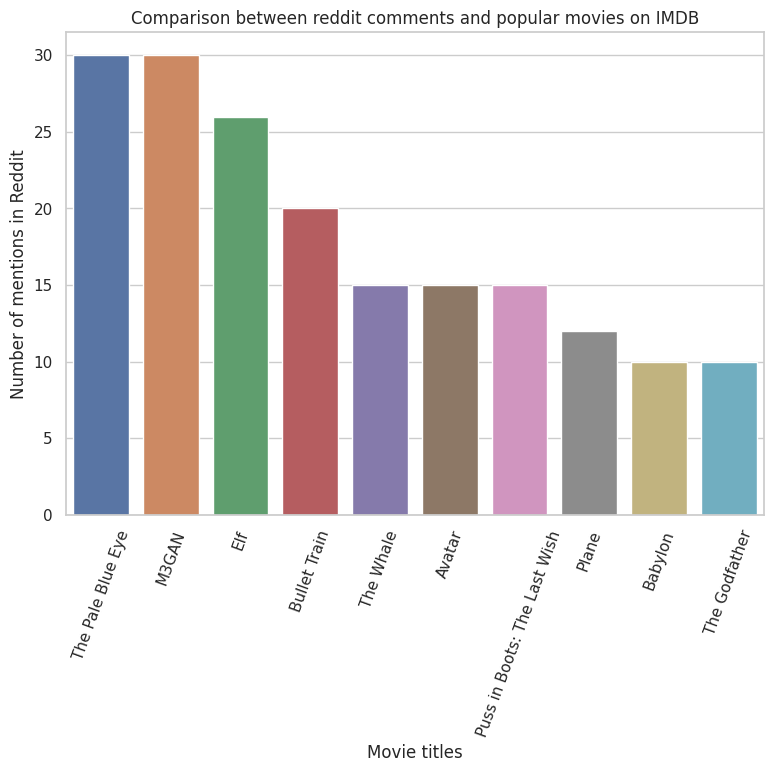

In [24]:
sns.set(rc={'figure.figsize':(9,6.27)})
sns.set_style("whitegrid")
sns.barplot(x=imdb_reddit_combined['movie_title'][:10],
            y=imdb_reddit_combined['count'][:10],
           )
plt.xticks(rotation = 70) # Rotates X-Axis Ticks by 45-degrees
plt.xlabel('Movie titles')
plt.ylabel('Number of mentions in Reddit')
plt.title('Comparison between reddit comments and popular movies on IMDB')
plt.show()

In [54]:
most_popular_by_years = (imdb
                         .select('movie_title', 'year')
                         .filter("movie_title is not null")
                         .distinct()
                         .groupby('year')                          
                         .count()
                         .orderBy(col("count").desc())
                         .toPandas())
most_popular_by_years['count'] = most_popular_by_years['count'].astype('int')
most_popular_by_years['year'].fillna(0, inplace=True)
most_popular_by_years['year'] = most_popular_by_years['year'].astype('int').astype('str')

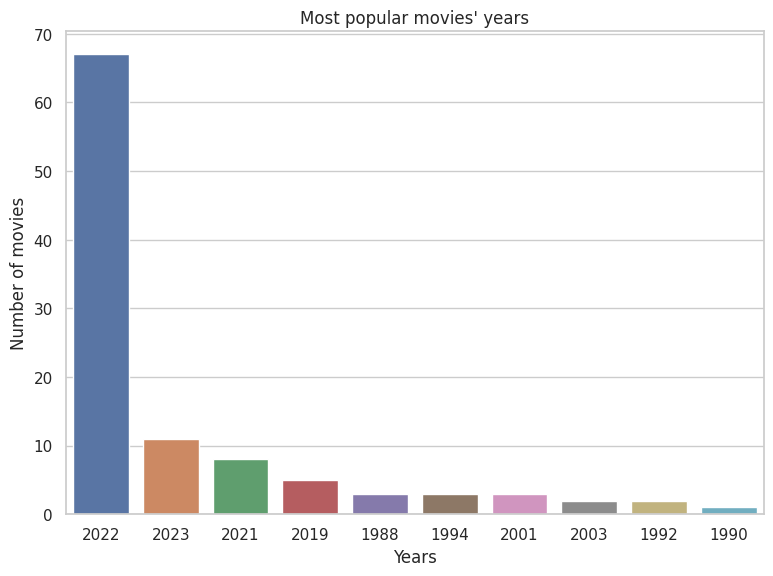

In [56]:
sns.set(rc={'figure.figsize':(9,6.27)})
sns.set_style("whitegrid")
sns.barplot(x=most_popular_by_years['year'][:10],
            y=most_popular_by_years['count'][:10],
           )
plt.xlabel('Years')
plt.ylabel('Number of movies')
plt.title("Most popular movies' years")
plt.show()

In [82]:
movie_rankings = (imdb
                 .select('movie_title', 'ranking_number')
                 .groupby('movie_title')                          
                 .min())

imdb_reddit_ = (result
                .select('title','text','movie_title',)
                .filter("movie_title is not null")
                .groupby("movie_title")
                .count()
                .orderBy(col("count").desc()))                    

In [79]:
result_combined = imdb_reddit_combined.join(movie_rankings,
                          imdb_reddit_combined.movie_title == movie_rankings.movie_title,
                          'outer').toPandas()


Text(0, 0.5, 'Number of mentions on Reddit')

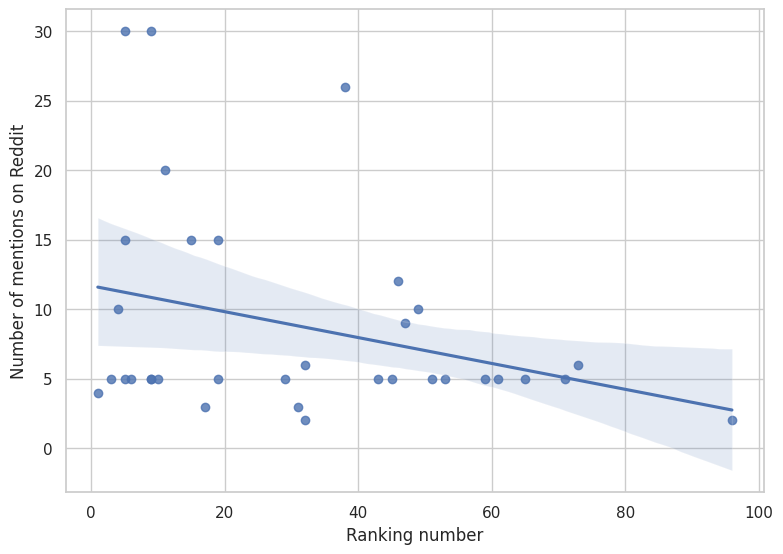

In [89]:
sns.regplot(x=result_combined['min(ranking_number)'],
                y=result_combined['count'])
plt.xlabel('Ranking number')
plt.ylabel('Number of mentions on Reddit')


In [101]:
comments = (reddit.select('num_comments')).toPandas()

Text(0.5, 0, 'Number of comments')

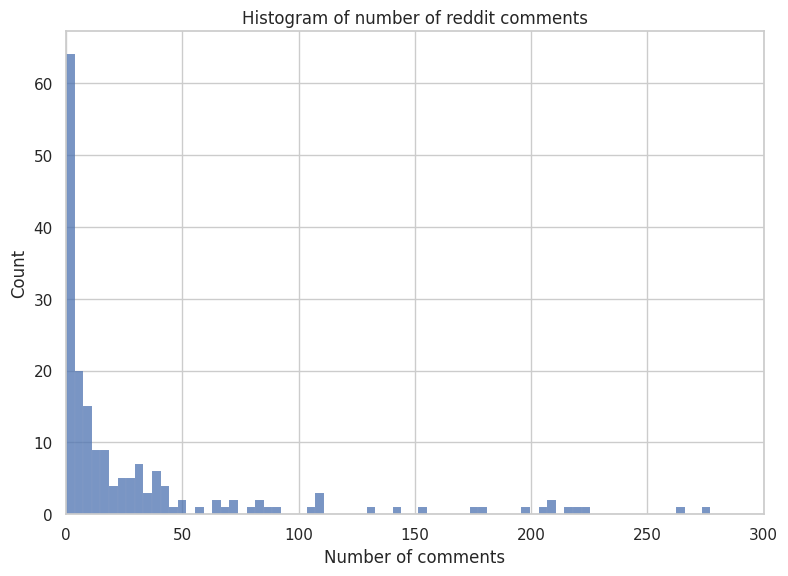

In [115]:
sns.histplot(comments['num_comments'],bins=2000)
plt.xlim(left=0, right=300)
plt.title('Histogram of number of reddit comments')
plt.xlabel('Number of comments')

